# Comparison of two means (T-test)

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
np.random.seed(1234)

In this notebook we demo two equivalent ways of performing a two-sample Bayesian t-test to compare the mean value of two Gaussian populations using Bambi.

## Generate data

We generate 160 values from a Gaussian with $\mu=6$ and $\sigma=2.5$ and another 120 values from a Gaussian'
with $\mu=8$ and $\sigma=2$

In [3]:
a = np.random.normal(6, 2.5, 160)
b = np.random.normal(8, 2, 120)
df = pd.DataFrame({"Group": ["a"] * 160 + ["b"] * 120, "Val": np.hstack([a, b])})

In [4]:
df.head()

,Group,Val
0,a,7.178588
1,a,3.022561
2,a,9.581767
3,a,5.218370
4,a,4.198528


/home/tomas/anaconda3/envs/bambi-dev/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/violinplot.py:65: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0)


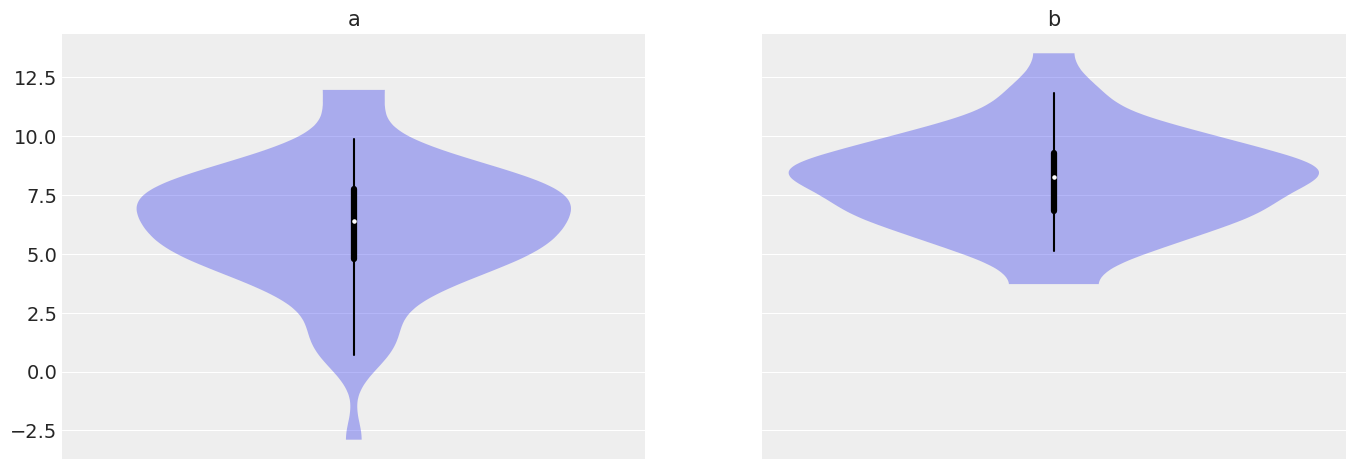

In [5]:
az.plot_violin({"a": a, "b": b});

When we carry out a two sample t-test we are implicitly using a linear model that can be specified in different ways. One of these approaches is the following:

### Model 1

$$
\mu_i = \beta_0 + \beta_1 (i) + \epsilon_i
$$

where $i = 0$ represents the population 1, $i = 1$ the population 2 and $\epsilon_i$ is a random error with mean 0. If we replace the indicator variables for the two groups we have 

$$
\mu_0 = \beta_0 + \epsilon_i
$$

and

$$
\mu_1 = \beta_0 + \beta_1 + \epsilon_i
$$

if $\mu_0 = \mu_1$ then

$$
\beta_0 + \epsilon_i = \beta_0 + \beta_1 + \epsilon_i\\
0 = \beta_1
$$

Thus, we can see that testing whether the mean of the two populations are equal is equivalent to testing whether $\beta_1$ is 0.

### Analysis

We start by instantiating our model and specifying the model previously described.

In [6]:
model_1 = bmb.Model("Val ~ Group", df)
results_1 = model_1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, Group]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


We've only specified the formula for the model and Bambi automatically selected priors distributions and values for their parameters. We can inspect both the setup and the priors as following:

In [7]:
model_1

       Formula: Val ~ Group
        Family: gaussian
          Link: mu = identity
  Observations: 280
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 6.9762, sigma: 8.1247)
            Group ~ Normal(mu: 0.0, sigma: 12.4107)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 2.4567)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [Group, Intercept, sigma]


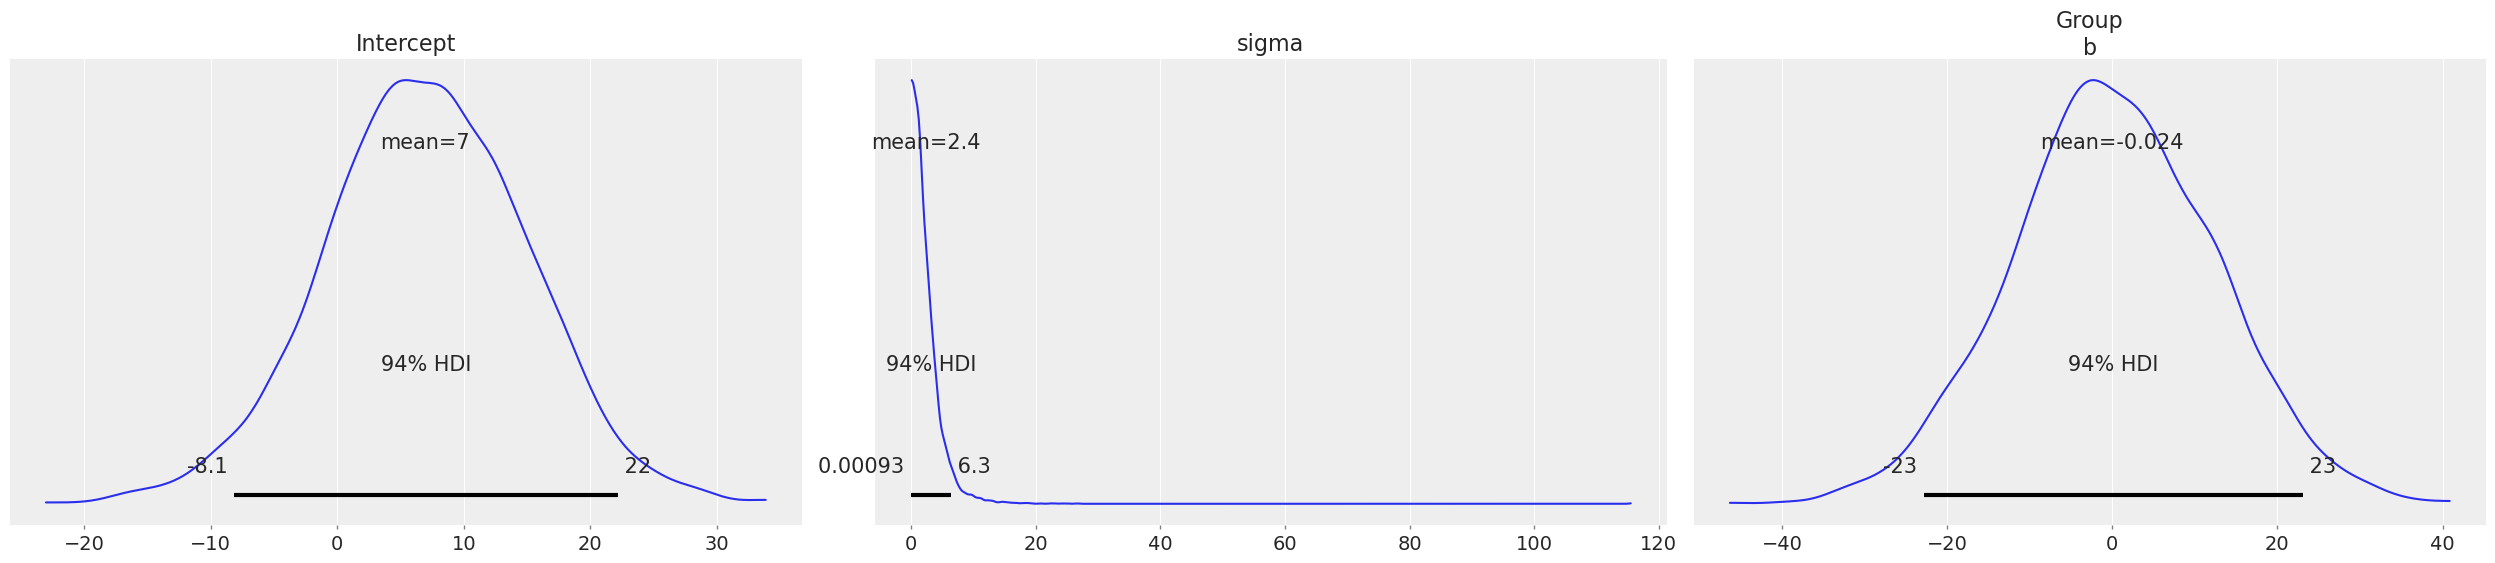

In [8]:
model_1.plot_priors();

To inspect our posterior and the sampling process we can call `az.plot_trace()`. The option `kind='rank_vlines'` gives us a variant of the rank plot that uses lines and dots and helps us to inspect the stationarity of the chains. Since there is no clear pattern or serious deviations from the horizontal lines, we can conclude the chains are stationary.

<!-- I think the reasoning is too simplistic but I don't know if we should make it more complicated here -->

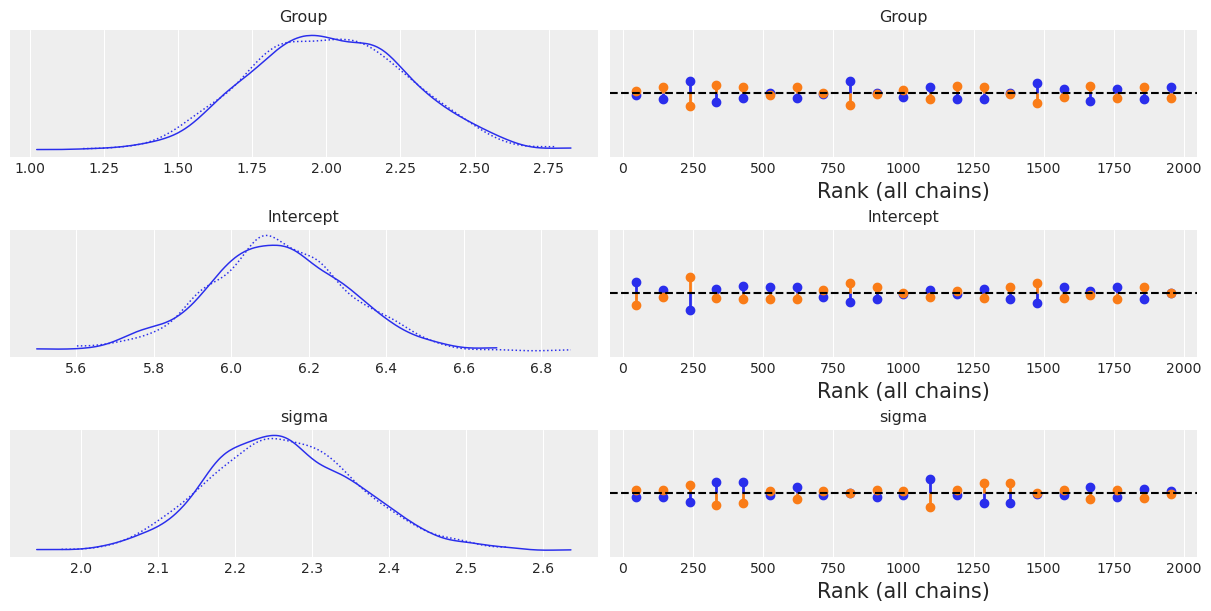

In [9]:
az.plot_trace(results_1, kind="rank_vlines");

In [10]:
az.summary(results_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Group[b],2.004,0.265,1.548,2.512,0.005,0.003,3036.0,1618.0,1.0
Intercept,6.117,0.180,5.777,6.459,0.003,0.002,3049.0,1512.0,1.0
sigma,2.265,0.096,2.087,2.444,0.002,0.001,3570.0,1662.0,1.0


In the summary table we can see the 94% highest density interval for $\beta_1$ ranges from 1.511 to 2.499. Thus, according to the data and the model used, we conclude the difference between the two population means is somewhere between 1.2 and 2.2 and hence we support the hypotehsis that $\beta_1 \ne 0$.

Similar conclusions can be made with the density estimate for the posterior distribution of $\beta_1$. As seen in the table, most of the probability for the difference in the mean roughly ranges from 1.2 to 2.2.

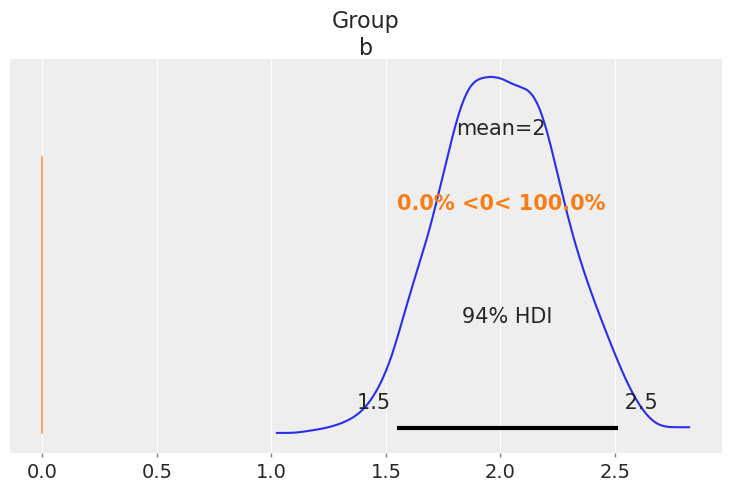

In [11]:
az.plot_posterior(results_1, var_names="Group", ref_val=0);

Another way to arrive to a similar conclusion is by calculating the probability that the parameter $\beta_1 > 0$. This probability is equal to 1, telling us that the mean of the two populations are different.

In [12]:
# Probabiliy that posterior is > 0
(results_1.posterior["Group"] > 0).mean().item()

1.0

The linear model implicit in the t-test can also be specified without an intercept term, such is the case of Model 2.

### Model 2

When we carry out a two sample t-test we're implicitly using the following model:

$$
\mu_i = \beta_i + \epsilon_i
$$

where $i = 0$ represents the population 1, $i = 1$ the population 2 and $\epsilon$ is a random error with mean 0. If we replace the indicator variables for the two groups we have 

$$
\mu_0 = \beta_0 + \epsilon
$$

and

$$
\mu_1 = \beta_1 + \epsilon
$$

if $\mu_0 = \mu_1$ then

$$
\beta_0 + \epsilon = \beta_1 + \epsilon\\
$$

Thus, we can see that testing whether the mean of the two populations are equal is equivalent to testing whether $\beta_0 = \beta_1$.

### Analysis

We start by instantiating our model and specifying the model previously described. In this model we will bypass the intercept that Bambi adds by default by setting it to zero, even though setting to -1 has the same effect.

In [13]:
model_2 = bmb.Model("Val ~ 0 + Group", df)
results_2 = model_2.fit() 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Group]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


We've only specified the formula for the model and Bambi automatically selected priors distributions and values for their parameters. We can inspect both the setup and the priors as following:

In [14]:
model_2

       Formula: Val ~ 0 + Group
        Family: gaussian
          Link: mu = identity
  Observations: 280
        Priors: 
    target = mu
        Common-level effects
            Group ~ Normal(mu: [0. 0.], sigma: [12.4107 12.4107])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 2.4567)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Sampling: [Group, sigma]


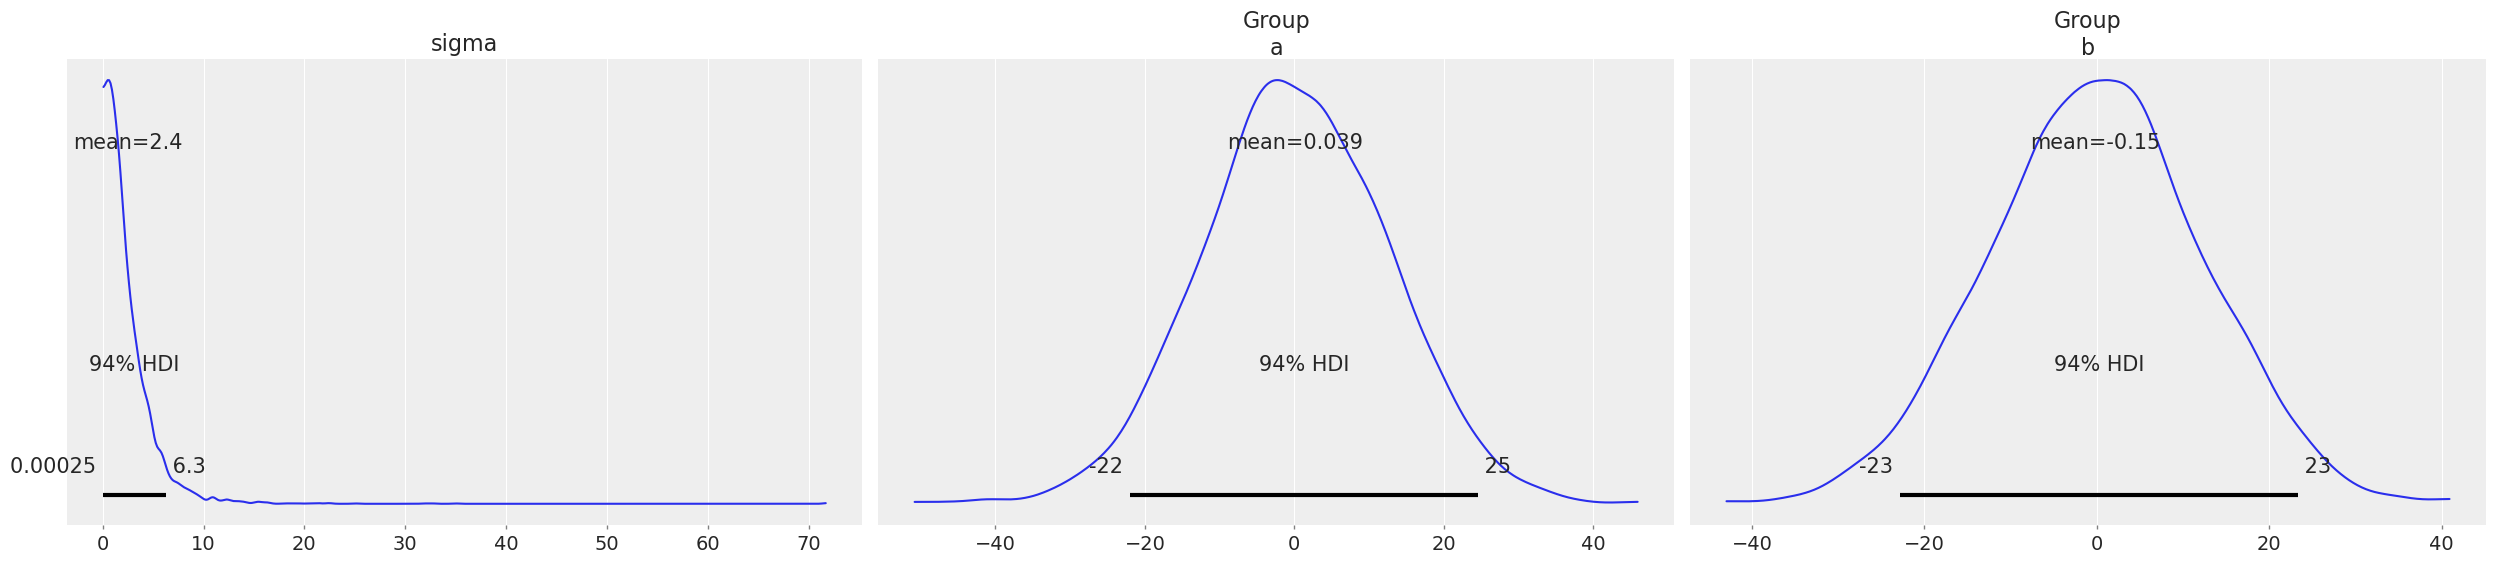

In [15]:
model_2.plot_priors();

To inspect our posterior and the sampling process we can call `az.plot_trace()`. The option `kind='rank_vlines'` gives us a variant of the rank plot that uses lines and dots and helps us to inspect the stationarity of the chains. Since there is no clear pattern or serious deviations from the horizontal lines, we can conclude the chains are stationary.

<!-- I think the reasoning is too simplistic but I don't know if we should make it more complicated here -->

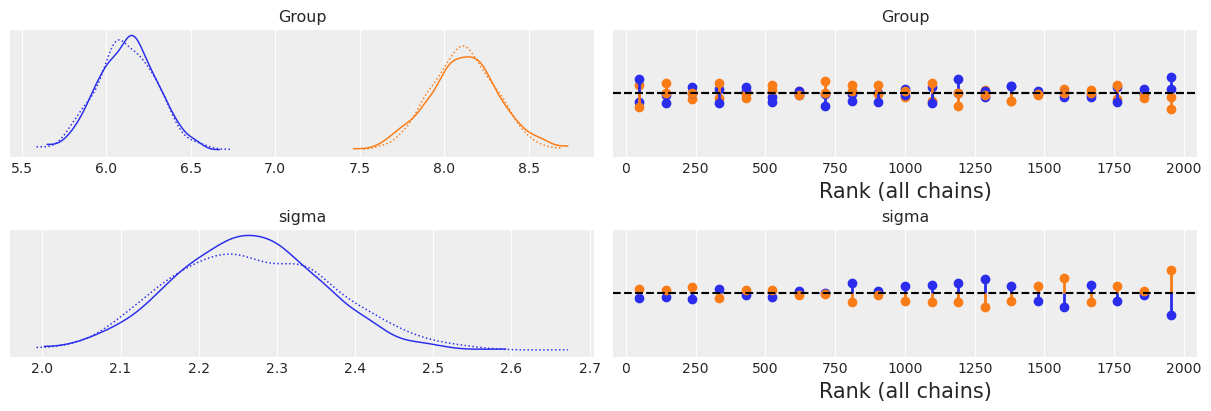

In [16]:
az.plot_trace(results_2, kind="rank_vlines");

In [17]:
az.summary(results_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Group[a],6.124,0.177,5.778,6.431,0.003,0.002,2735.0,1407.0,1.00
Group[b],8.115,0.203,7.708,8.474,0.004,0.003,3086.0,1621.0,1.00
sigma,2.265,0.099,2.075,2.437,0.002,0.001,2884.0,1630.0,1.01


In this summary we can observe the estimated distribution of means for each population. A simple way to compare them is subtracting one to the other. In the next plot we can se that the entirety of the distribution of differences is higher than zero and that the mean of population 2 is higher than the mean of population 1 by a mean of 2.

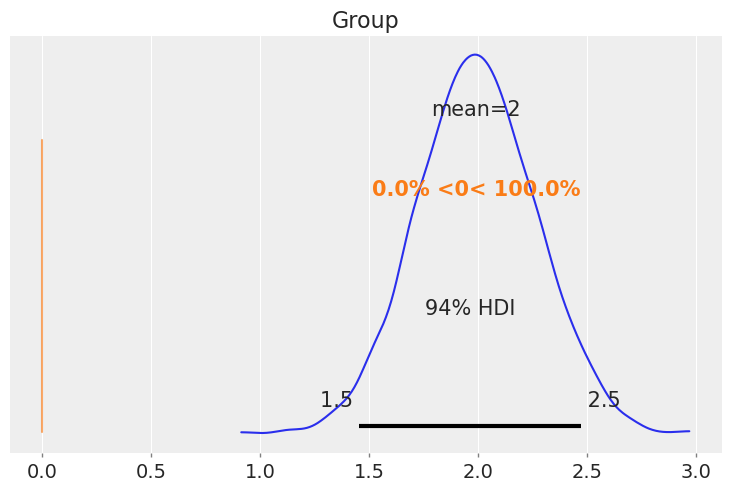

In [18]:
post_group = results_2.posterior["Group"]
diff = post_group.sel(Group_dim="b") - post_group.sel(Group_dim="a") 
az.plot_posterior(diff, ref_val=0);

Another way to arrive to a similar conclusion is by calculating the probability that the parameter $\beta_1 - \beta_0 > 0$. This probability equals to 1, telling us that the mean of the two populations are different.

In [19]:
# Probabiliy that posterior is > 0
(post_group > 0).mean().item()

1.0

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat May 25 2024

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.24.0

pandas    : 2.2.2
matplotlib: 3.8.4
arviz     : 0.18.0
bambi     : 0.13.1.dev37+g2a54df76.d20240525
numpy     : 1.26.4

Watermark: 2.4.3

